I declare that this submission is my own work, and that I did not use any pretrained model or code that I did not explicitly cite.


In [1]:
# import libraries

# general libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# libraries for traing, testing, evaluating model
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint



## Data Inspection


In [2]:
# Load data
data = np.load('dataset_dev_3000.npz')

# Explore keys
print("Keys:", data.files)

# Extract arrays
X = data['X']
y = data['y']

print("X shape:", X.shape)
print("y shape:", y.shape)


Keys: ['X', 'y']
X shape: (3000, 32, 32)
y shape: (3000, 3)


In [3]:
# Count number of samples per class
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")


Class 0.0: 387 samples
Class 0.00026430911384522915: 1 samples
Class 0.0012721653329208493: 1 samples
Class 0.001568699604831636: 1 samples
Class 0.001762773492373526: 1 samples
Class 0.0018284324323758483: 1 samples
Class 0.0019072487484663725: 1 samples
Class 0.0020356904715299606: 1 samples
Class 0.0021006499882787466: 1 samples
Class 0.0026393872685730457: 1 samples
Class 0.003119604429230094: 1 samples
Class 0.0033321119844913483: 1 samples
Class 0.0034062291961163282: 1 samples
Class 0.0035183411091566086: 1 samples
Class 0.003814652096480131: 1 samples
Class 0.003852665890008211: 1 samples
Class 0.003922072239220142: 1 samples
Class 0.004057707265019417: 1 samples
Class 0.004159008618444204: 1 samples
Class 0.004307989031076431: 1 samples
Class 0.0043214308097958565: 1 samples
Class 0.0043290406465530396: 1 samples
Class 0.0044805440120399: 1 samples
Class 0.005482145119458437: 1 samples
Class 0.00564561178907752: 1 samples
Class 0.005840257741510868: 1 samples
Class 0.005890033

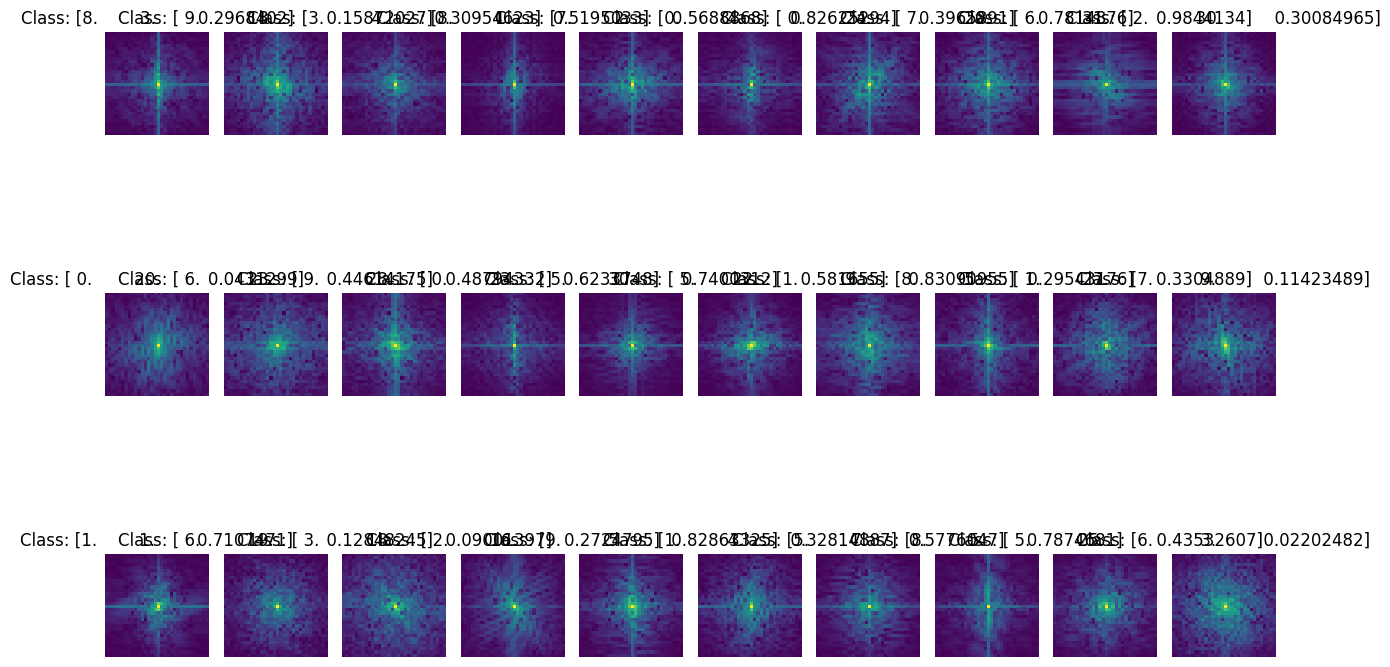

In [4]:
num_images = 30
rows = 3
cols = 10 

plt.figure(figsize=(12, 9))

# Pick 10 random indices
random_indices = np.random.choice(len(X), num_images, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx])
    plt.title(f"Class: {y[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing


In [ ]:
# Normalize images
X = X.astype('float32') / 255.0

# Convert (16000, 32, 32) → (16000, 32, 32, 1)
X = X[..., np.newaxis]

# Convert labels to categorical (one-hot)
y_cat = to_categorical(y, num_classes=4)

print("X shape:", X.shape)
print("y shape:", y_cat.shape)

X shape: (16000, 32, 32, 1)
y shape: (16000, 4)


In [ ]:
# Train test split at 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (12800, 32, 32, 1) (12800, 4)
Test shape: (3200, 32, 32, 1) (3200, 4)


## Data Augmentation


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_gen = datagen.flow(X_train, y_train, batch_size=32, subset='training')
val_gen = datagen.flow(X_train, y_train, batch_size=32, subset='validation')

## Architecture
